In [ ]:
!pip install tensorflow-gpu


     |████████████████████████████████| 454.3MB 33kB/s 


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
import numpy as np 
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

100% 3.23G/3.24G [00:38<00:00, 100MB/s] 
100% 3.24G/3.24G [00:39<00:00, 89.2MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00435.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00436.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00437.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00438.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00439.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00440.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00441.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00442.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00443.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00444.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00445.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00446.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00447.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00448.png  
  inflating: Fish_Dataset/Fish_Dataset/

In [ ]:
direc = Path('Fish_Dataset/Fish_Dataset')
filepaths = list(direc.glob(r'**/*.png'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))



filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)


img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ]

#Resampling it
img_df=img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

,FilePaths,Labels
0,Fish_Dataset/Fish_Dataset/Gilt-Head Bream/Gilt...,Gilt-Head Bream
1,Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass/00...,Sea Bass
2,Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00773.png,Shrimp
3,Fish_Dataset/Fish_Dataset/Black Sea Sprat/Blac...,Black Sea Sprat
4,Fish_Dataset/Fish_Dataset/Trout/Trout/00207.png,Trout


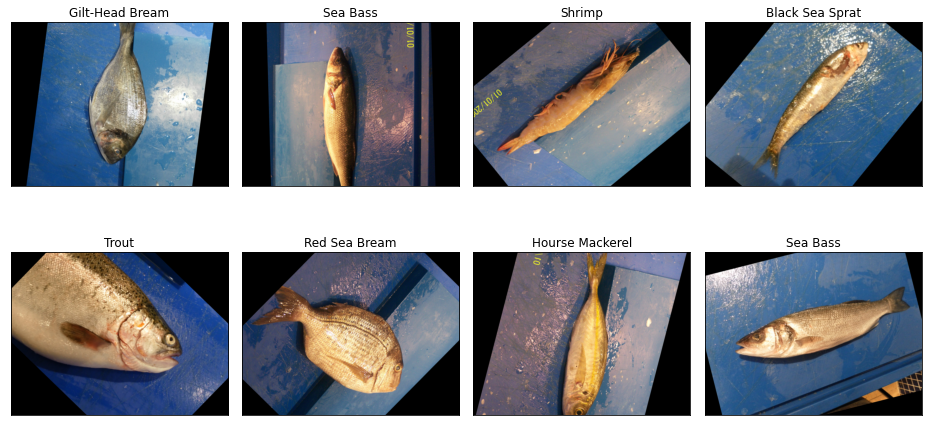

In [ ]:
import matplotlib.pyplot as plt
f,a = plt.subplots(nrows=2, ncols=4, figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])
    
plt.tight_layout()
plt.show()

In [ ]:
print(f" Count of Rows : {img_df.shape[0]} \n Count of Columns : {img_df.shape[1]} ")

 Count of Rows : 9000 
 Count of Columns : 2 


In [ ]:
img_df['Labels'].value_counts(ascending=True)

Trout                 1000
Shrimp                1000
Red Sea Bream         1000
Hourse Mackerel       1000
Sea Bass              1000
Black Sea Sprat       1000
Striped Red Mullet    1000
Gilt-Head Bream       1000
Red Mullet            1000
Name: Labels, dtype: int64

In [ ]:
train_ratio = 0.75
validation_ratio = 0.10
test_ratio = 0.15


x_train, x_test = train_test_split(img_df, test_size=1 - train_ratio)
x_val, x_test = train_test_split(x_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(f'Shape of Training Data : ',x_train.shape)
print(f'Shape of Testing Data : ',x_test.shape)
print(f'Shape of Validation Data : ',x_val.shape)
x_testt = x_test.copy()

Shape of Training Data :  (6750, 2)
Shape of Testing Data :  (1350, 2)
Shape of Validation Data :  (900, 2)


In [ ]:
img_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

img_size=(224, 224)    

x_train = img_datagen.flow_from_dataframe(dataframe = x_train, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_test = img_datagen.flow_from_dataframe(dataframe = x_test, x_col='FilePaths', y_col='Labels', target_size=img_size,color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_val = img_datagen.flow_from_dataframe(dataframe = x_val, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)

Found 6750 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


In [ ]:
fc_model = tf.keras.models.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Flatten(input_shape=(113,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(9,activation="softmax")
])

fc_model.compile(optimizer="adam",
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [ ]:
Callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
mo_fit = fc_model.fit(x_train,
                validation_data = x_val,
                epochs = 10, callbacks=Callback)

Epoch 1/10
211/211 [==============================] - 95s 451ms/step - loss: 0.6328 - accuracy: 0.7787 - val_loss: 0.4689 - val_accuracy: 0.8489
Epoch 2/10
211/211 [==============================] - 95s 450ms/step - loss: 0.4654 - accuracy: 0.8387 - val_loss: 0.3725 - val_accuracy: 0.8833
Epoch 3/10
211/211 [==============================] - 99s 468ms/step - loss: 0.3583 - accuracy: 0.8769 - val_loss: 0.3405 - val_accuracy: 0.8889
Epoch 4/10
211/211 [==============================] - 96s 455ms/step - loss: 0.2718 - accuracy: 0.9101 - val_loss: 0.2906 - val_accuracy: 0.9033
Epoch 5/10
211/211 [==============================] - 97s 457ms/step - loss: 0.2167 - accuracy: 0.9261 - val_loss: 0.2241 - val_accuracy: 0.9267
Epoch 6/10
211/211 [==============================] - 97s 460ms/step - loss: 0.1853 - accuracy: 0.9361 - val_loss: 0.2748 - val_accuracy: 0.9078
Epoch 7/10
211/211 [==============================] - 97s 458ms/step - loss: 0.1426 - accuracy: 0.9532 - val_loss: 0.1896 - val_ac

In [ ]:
print('Model summary :')
print()
fc_model.summary()

Model summary :

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, None, None, None)  0         
_________________________________________________________________
flatten (Flatten)            (None, None)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               19267712  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 9) 

In [ ]:
test_accuracy = fc_model.evaluate(x_test)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

43/43 [==============================] - 18s 427ms/step - loss: 0.1401 - accuracy: 0.9541
Test accuracy is :  95.40740847587585 %


In [ ]:
accuracy = mo_fit.history['accuracy']
loss = mo_fit.history['loss']
validation_loss = mo_fit.history['val_loss']
validation_accuracy = mo_fit.history['val_accuracy']


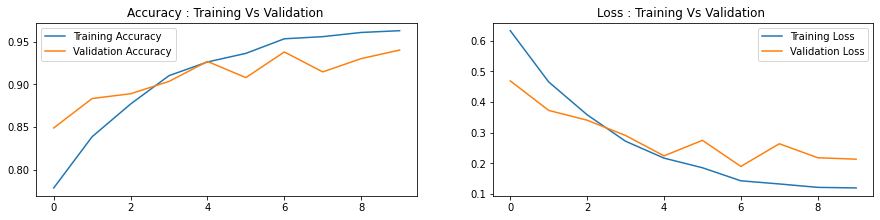

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(2, 2, 1)
plt.plot(range(10), accuracy, label='Training Accuracy')
plt.plot(range(10), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy : Training Vs Validation ')



plt.subplot(2, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')
plt.show()

In [ ]:
predictions = fc_model.predict(x_test)
preds = np.argmax(predictions, axis=1)
preds

array([6, 6, 3, ..., 2, 8, 5])